In [1]:
!pip install statsmodels

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


In [3]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dump2.csv', na_filter=True)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

'''
'cpu_percent', 'cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
                   'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches', 'cpu_numbers_of_interrupts',
                   'cpu_numbers_of_soft_interrupts','cpu_load_runable_state','memory_percent','memory_active',
                   'memory_cached','memory_shared','memory_swap_percent','memory_swap_sin','memory_swap_sout',
                   'disk_usage_percent','disk_read_count','disk_write_count','disk_read_time','disk_write_time'
'''

df = df.drop(columns=['cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
                   'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches', 'cpu_numbers_of_interrupts',
                   'cpu_numbers_of_soft_interrupts','cpu_load_runable_state','memory_active',
                   'memory_cached','memory_shared','memory_swap_percent','memory_swap_sin','memory_swap_sout',
                   'disk_read_count','disk_write_count','disk_read_time','disk_write_time'])

print(df.shape)  # (2503, 23)
df.tail()

(2503, 4)


,cpu_percent,cpu_irq,memory_percent,disk_usage_percent
2498,0.7,0,2983067648,318953
2499,0.7,0,2983067648,318953
2500,1.3,0,2983071744,318953
2501,0.8,0,2983079936,318953
2502,0.9,0,2983092224,318953


In [4]:
def remove_constant_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]

drop_col = remove_constant_value_features(df)
df.drop(drop_col,axis=1,inplace=True)
print(df.shape)  # (2503, 23)
df.tail()

(2503, 3)


,cpu_percent,memory_percent,disk_usage_percent
2498,0.7,2983067648,318953
2499,0.7,2983067648,318953
2500,1.3,2983071744,318953
2501,0.8,2983079936,318953
2502,0.9,2983092224,318953


IndexError: ignored

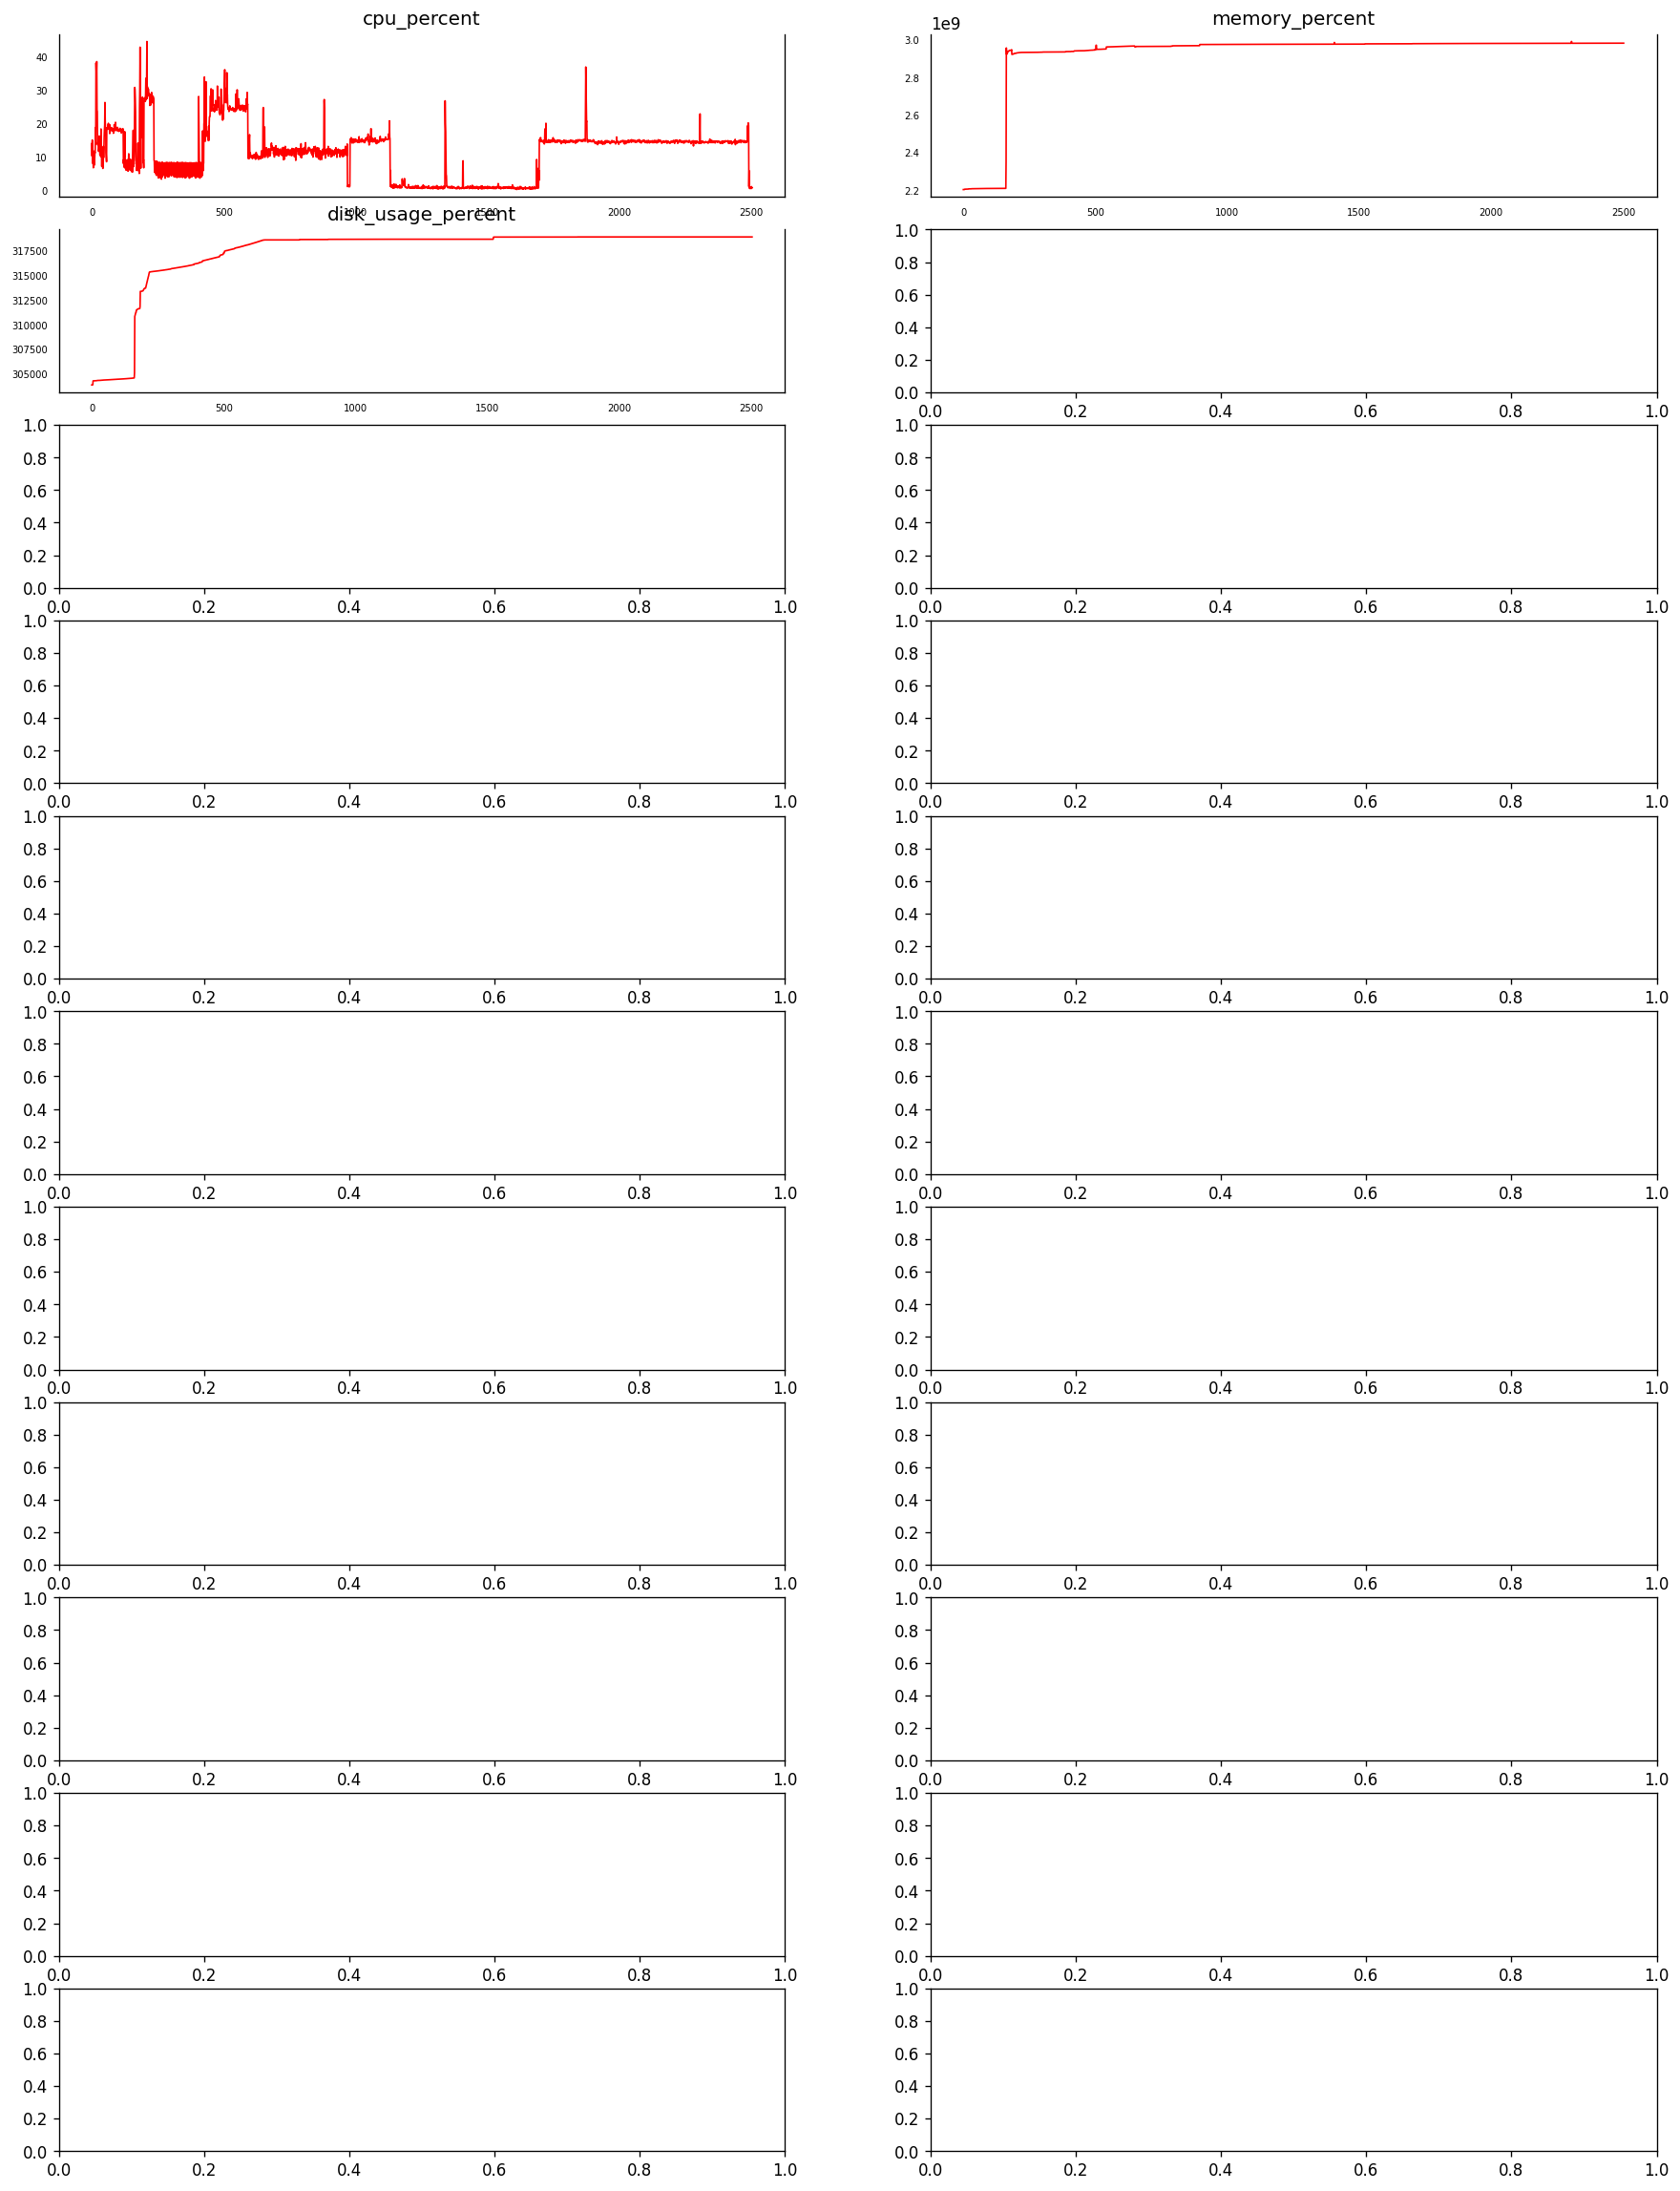

In [5]:
# Plot
fig, axes = plt.subplots(nrows=11, ncols=2, dpi=120, figsize=(18,24))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=40
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,cpu_percent_x,memory_percent_x,disk_usage_percent_x
cpu_percent_y,1.0,0.0,0.0
memory_percent_y,0.0,1.0,0.0
disk_usage_percent_y,0.0,0.0,1.0


In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
cpu_percent ::  57.75     > 24.2761   =>   True
memory_percent ::  21.85     > 12.3212   =>   True
disk_usage_percent ::  4.08      > 4.1296    =>   False


In [8]:
nobs = 500
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (2403, 22)
print(df_test.shape)  # (100, 22)

(2003, 3)
(500, 3)


In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [10]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cpu_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7344
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0683. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "memory_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3883
 No. Lags Chosen       = 2
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0114. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "disk_usage_percent" 
    -----------------------------------------------
 Null Hypothesis: Data h

In [11]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [12]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cpu_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.0953
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "memory_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -29.9418
 No. Lags Chosen       = 1
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "disk_usage_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

In [ ]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [13]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cpu_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.0953
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "memory_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -29.9418
 No. Lags Chosen       = 1
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "disk_usage_percent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

In [14]:
model = VAR(df_differenced)
for i in range(1,40,1):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  42.34161568607418
BIC :  42.375207304272585
FPE :  2.44754144321952e+18
HQIC:  42.3539495121369 

Lag Order = 2
AIC :  42.299915862616956
BIC :  42.35872533844215
FPE :  2.347578272528985e+18
HQIC:  42.32150946930026 

Lag Order = 3
AIC :  42.18812321589307
BIC :  42.272171274940106
FPE :  2.0992744654273267e+18
HQIC:  42.21898468216544 

Lag Order = 4
AIC :  42.16394623992707
BIC :  42.27325363552724
FPE :  2.0491295986203587e+18
HQIC:  42.20408365588012 

Lag Order = 5
AIC :  42.10793559254641
BIC :  42.2425231058183
FPE :  1.937512526113037e+18
HQIC:  42.1573570594157 

Lag Order = 6
AIC :  42.092589890696985
BIC :  42.252478330597626
FPE :  1.9080083359779707e+18
HQIC:  42.151303520882955 

Lag Order = 7
AIC :  42.074450534068575
BIC :  42.259660737444705
FPE :  1.8737120981721498e+18
HQIC:  42.142464451157416 

Lag Order = 8
AIC :  42.081546675051285
BIC :  42.292099506690775
FPE :  1.8870578879379735e+18
HQIC:  42.158869013835975 

Lag Order = 9
AIC :  42.070

In [15]:
x = model.select_order(maxlags=40)
x.summary()

,AIC,BIC,FPE,HQIC
0,42.65,42.66,3.322e+18,42.65
1,42.28,42.31,2.291e+18,42.29
2,42.23,42.29,2.186e+18,42.25
3,42.09,42.18,1.905e+18,42.12
4,42.06,42.17,1.852e+18,42.10
5,42.04,42.17,1.802e+18,42.09
6,42.02,42.18,1.773e+18,42.08
7,42.00,42.19,1.740e+18,42.07
8,42.01,42.22,1.749e+18,42.08
9,41.99,42.23,1.724e+18,42.08


In [16]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Apr, 2023
Time:                     01:34:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    42.3065
Nobs:                     1993.00    HQIC:                   42.1572
Log likelihood:          -50323.2    FPE:                1.86649e+18
AIC:                      42.0706    Det(Omega_mle):     1.78998e+18
--------------------------------------------------------------------
Results for equation cpu_percent
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.020596         0.055524            0.371           0.711
L1.cpu_percent               -0.291779         0.022438          -13.004           0.000
L1.memory_percent     

In [17]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

cpu_percent : 1.99
memory_percent : 2.0
disk_usage_percent : 2.0


In [18]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

9


array([[-3.0000e-01,  0.0000e+00,  0.0000e+00],
       [-2.0000e-01,  0.0000e+00,  0.0000e+00],
       [-2.0000e-01,  1.2288e+04,  0.0000e+00],
       [-2.0000e-01,  0.0000e+00,  0.0000e+00],
       [ 5.0000e-01,  0.0000e+00,  0.0000e+00],
       [ 1.0000e-01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 3.0000e-01,  1.6384e+04,  0.0000e+00],
       [-1.0000e-01,  0.0000e+00,  0.0000e+00]])

In [30]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,cpu_percent_1d,memory_percent_1d,disk_usage_percent_1d
2003,0.007968,306219.751059,5.561893
2004,-0.060434,379691.510064,6.896500
2005,-0.027977,605429.188979,8.236226
2006,0.008468,376025.610497,6.366722
2007,0.000680,466306.683539,7.837258
...,...,...,...
2498,0.002668,389277.056433,7.342541
2499,0.002668,389277.056433,7.342541
2500,0.002668,389277.056433,7.342541
2501,0.002668,389277.056433,7.342541


In [31]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [32]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)    
'''    
df_results.loc[:, ['cpu_percent_forecast', 'cpu_user_time_forecast', 'cpu_system_time_forecast', 'cpu_idle_time_forecast',
                   'cpu_iowait_forecast', 'cpu_softirq_forecast', 'cpu_numbers_of_ctx_switches_forecast', 'cpu_numbers_of_interrupts_forecast',
                   'cpu_numbers_of_soft_interrupts_forecast','cpu_load_runable_state_forecast','memory_percent_forecast','memory_active_forecast',
                   'memory_cached_forecast','memory_shared_forecast','memory_swap_percent_forecast','memory_swap_sin_forecast','memory_swap_sout_forecast',
                   'disk_usage_percent_forecast','disk_read_count_forecast','disk_write_count_forecast','disk_read_time_forecast','disk_write_time_forecast']]
'''

df_results.loc[:, ['cpu_percent_forecast','memory_percent_forecast','disk_usage_percent_forecast']]

,cpu_percent_forecast,memory_percent_forecast,disk_usage_percent_forecast
2003,14.707968,2.981940e+09,318958.561893
2004,14.647534,2.982320e+09,318965.458393
2005,14.619556,2.982925e+09,318973.694619
2006,14.628025,2.983301e+09,318980.061341
2007,14.628705,2.983768e+09,318987.898599
...,...,...,...
2498,15.934702,3.174776e+09,322589.746479
2499,15.937370,3.175165e+09,322597.089020
2500,15.940037,3.175554e+09,322604.431562
2501,15.942705,3.175943e+09,322611.774103


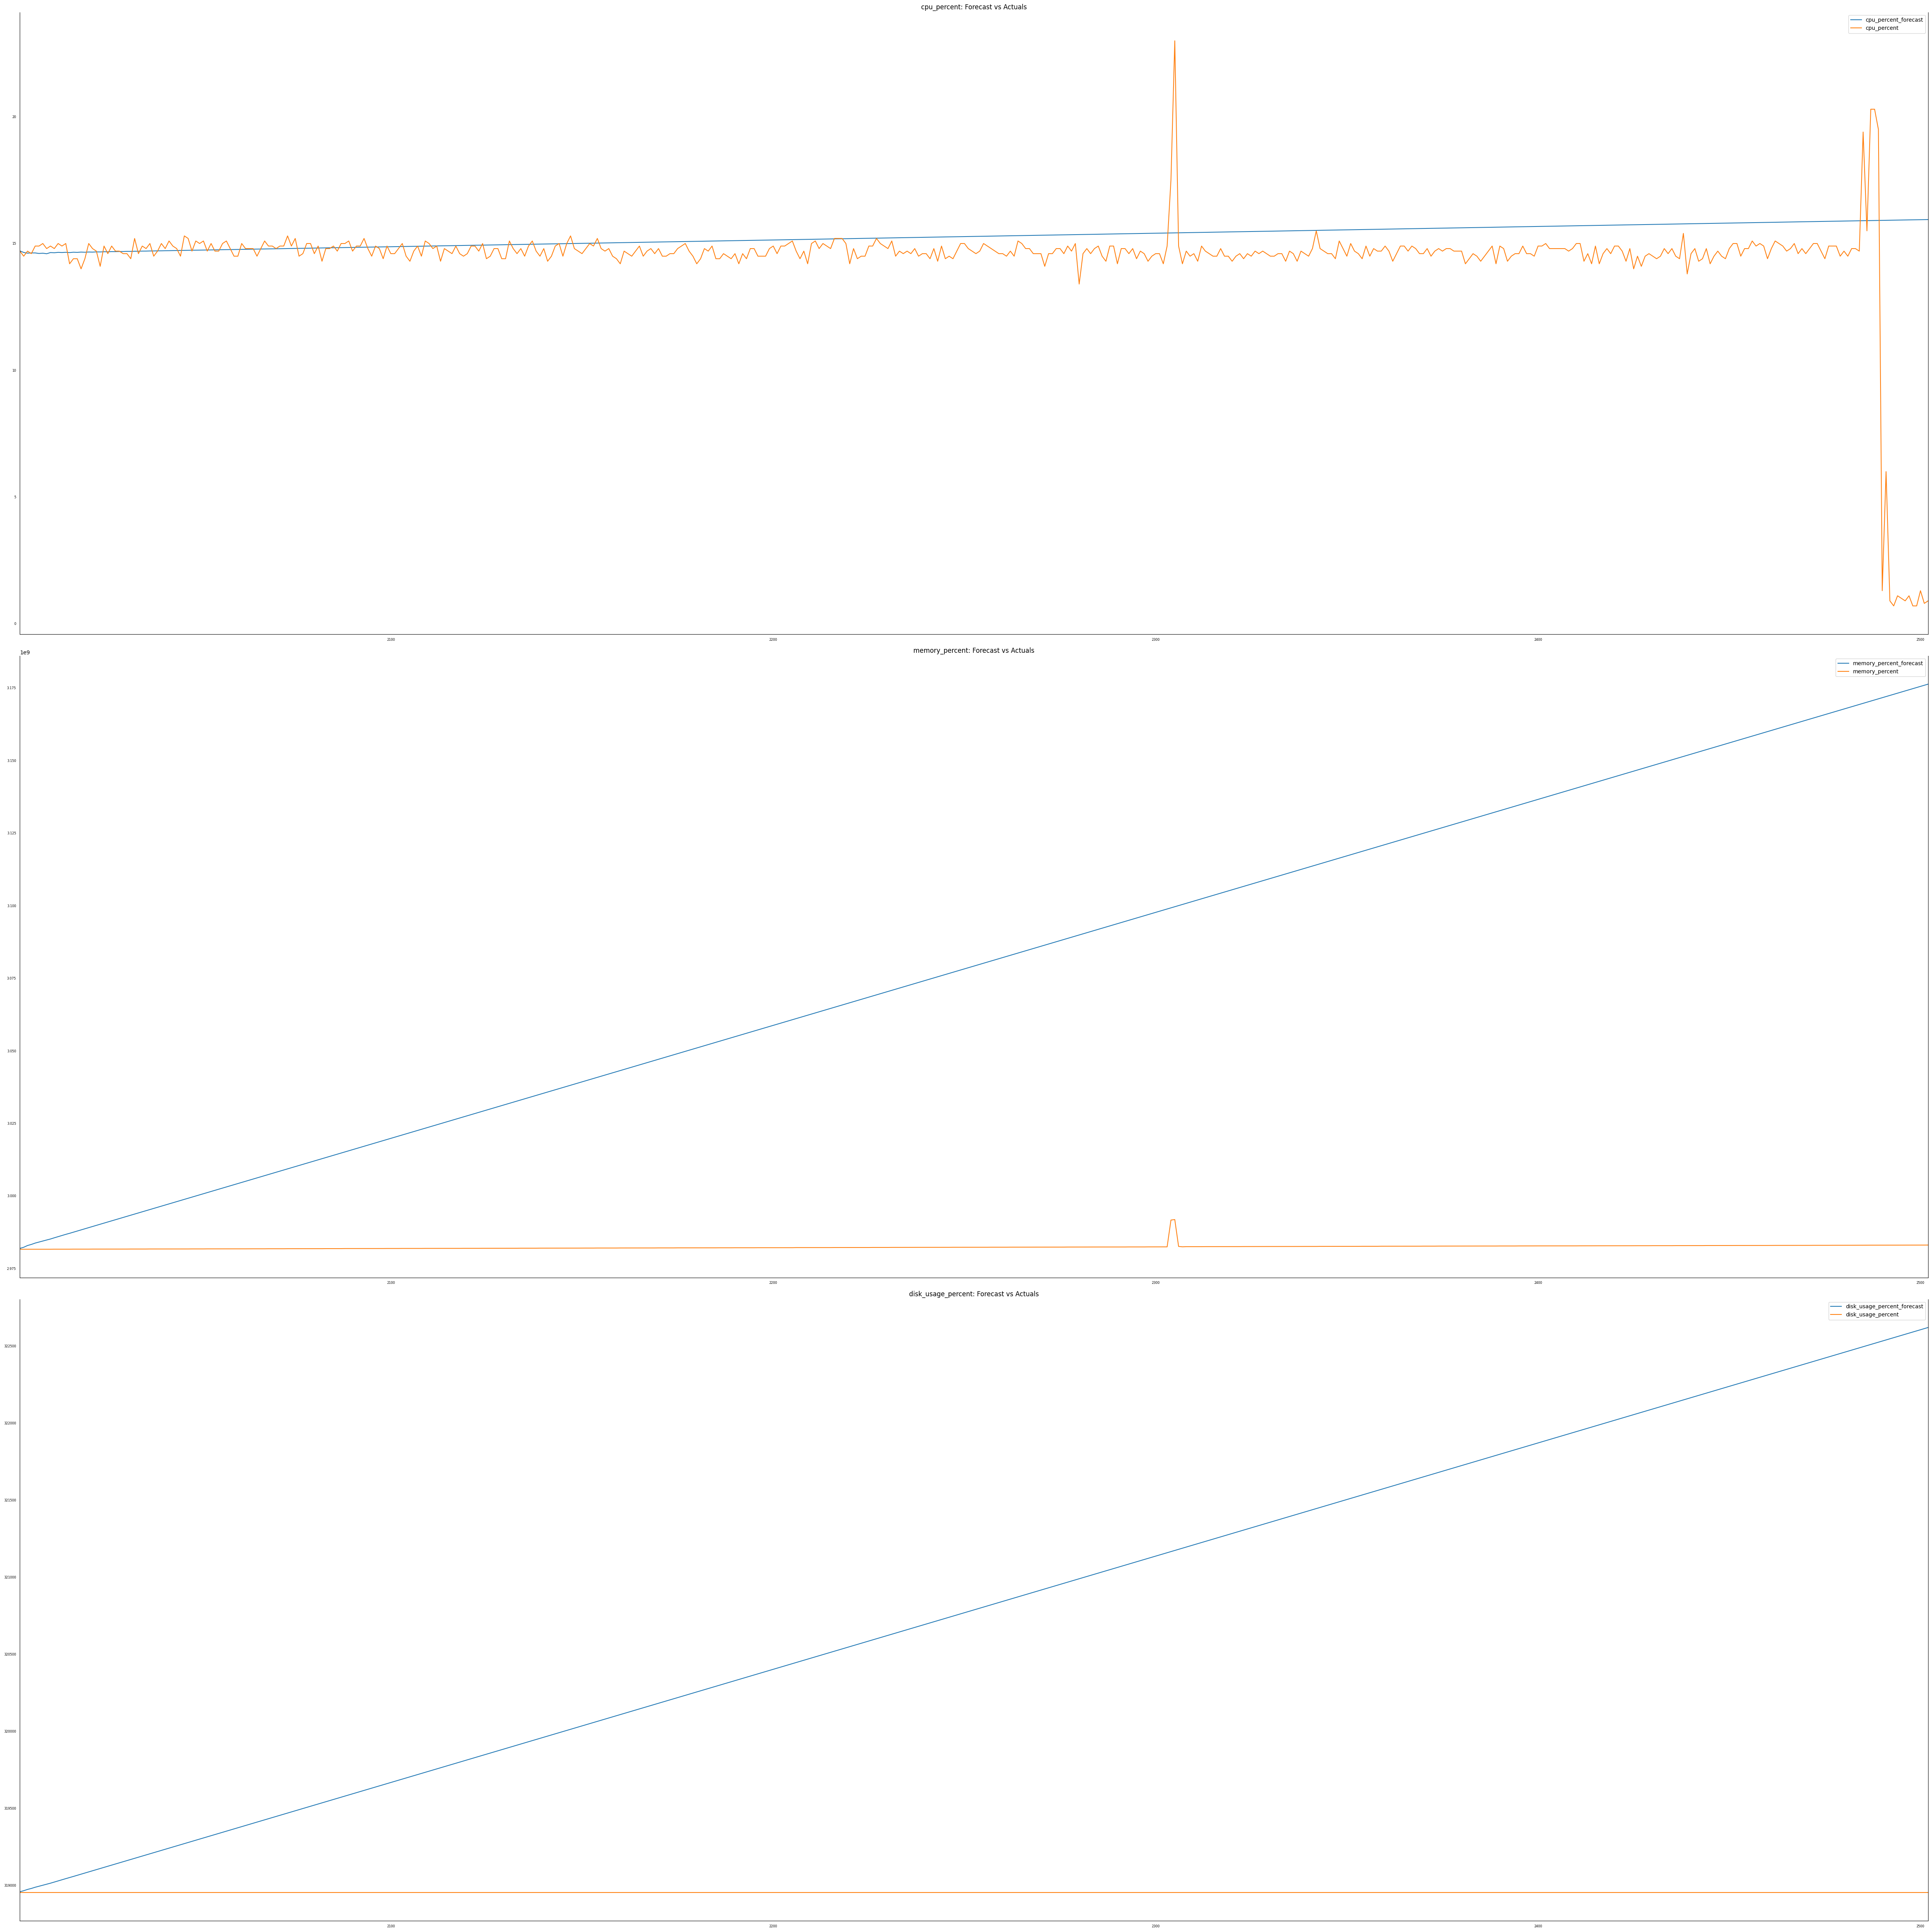

In [37]:
#fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=3, dpi=100, figsize=(50,8))

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(50,50))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [38]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: cpu_percent')
accuracy_prod = forecast_accuracy(df_results['cpu_percent_forecast'].values, df_test['cpu_percent'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_user_time')
accuracy_prod = forecast_accuracy(df_results['cpu_user_time_forecast'].values, df_test['cpu_user_time'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_system_time')
accuracy_prod = forecast_accuracy(df_results['cpu_system_time_forecast'].values, df_test['cpu_system_time'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_idle_time')
accuracy_prod = forecast_accuracy(df_results['cpu_idle_time_forecast'].values, df_test['cpu_idle_time'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_iowait')
accuracy_prod = forecast_accuracy(df_results['cpu_iowait_forecast'].values, df_test['cpu_iowait'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_softirq')
accuracy_prod = forecast_accuracy(df_results['cpu_softirq_forecast'].values, df_test['cpu_softirq'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_numbers_of_ctx_switches')
accuracy_prod = forecast_accuracy(df_results['cpu_numbers_of_ctx_switches_forecast'].values, df_test['cpu_numbers_of_ctx_switches'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_numbers_of_interrupts')
accuracy_prod = forecast_accuracy(df_results['cpu_numbers_of_interrupts_forecast'].values, df_test['cpu_numbers_of_interrupts'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_numbers_of_soft_interrupts')
accuracy_prod = forecast_accuracy(df_results['cpu_numbers_of_soft_interrupts_forecast'].values, df_test['cpu_numbers_of_soft_interrupts'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: cpu_load_runable_state')
accuracy_prod = forecast_accuracy(df_results['cpu_load_runable_state_forecast'].values, df_test['cpu_load_runable_state'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_percent')
accuracy_prod = forecast_accuracy(df_results['memory_percent_forecast'].values, df_test['memory_percent'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_active')
accuracy_prod = forecast_accuracy(df_results['memory_active_forecast'].values, df_test['memory_active'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_cached')
accuracy_prod = forecast_accuracy(df_results['memory_cached_forecast'].values, df_test['memory_cached'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_shared')
accuracy_prod = forecast_accuracy(df_results['memory_shared_forecast'].values, df_test['memory_shared'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_swap_percent')
accuracy_prod = forecast_accuracy(df_results['memory_swap_percent_forecast'].values, df_test['memory_swap_percent'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_swap_sin')
accuracy_prod = forecast_accuracy(df_results['memory_swap_sin_forecast'].values, df_test['memory_swap_sin'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: memory_swap_sout')
accuracy_prod = forecast_accuracy(df_results['memory_swap_sout_forecast'].values, df_test['memory_swap_sout'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: disk_usage_percent')
accuracy_prod = forecast_accuracy(df_results['disk_usage_percent_forecast'].values, df_test['disk_usage_percent'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: disk_read_count')
accuracy_prod = forecast_accuracy(df_results['disk_read_count_forecast'].values, df_test['disk_read_count'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: disk_write_count')
accuracy_prod = forecast_accuracy(df_results['disk_write_count_forecast'].values, df_test['disk_write_count'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: disk_read_time')
accuracy_prod = forecast_accuracy(df_results['disk_read_time_forecast'].values, df_test['disk_read_time'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: disk_write_time')
accuracy_prod = forecast_accuracy(df_results['disk_write_time_forecast'].values, df_test['disk_write_time'])
for k, v in accuracy_prod.items():
     print(k, ': ', round(v,4))

Forecast Accuracy of: cpu_percent
mape :  0.4434
me :  0.8609
mae :  1.0174
mpe :  0.4348
rmse :  2.5202
corr :  -0.2424
minmax :  0.0643

Forecast Accuracy of: cpu_user_time


<ipython-input-38-9a76dd756c68>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-38-9a76dd756c68>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


KeyError: ignored